# Automatic Essay Scoring (AES)

Automatic Essay Scoring (AES) é uma tarefa de machine learning que consistem em atribuir uma nota para redação de maneira automática.
No geral, diversas abordagens na literatura apresentaram resultados significativos na tentativa de realizar esse processo utilizando diversas técnicas e algoritmos focando em diferentes aspectos como analise da corretude gramatical, existência de estrutura retórica entre outras.

Essencialmente, AES consiste em duas principais abordagens, a primeira usa regressão para atribuir uma nota ao texto de entrada, enquanto a segunda tenta classificar a nota em um intervalo predeterminado e fixo, por exemplo, (e.g 0, 50, 100, 150, 200) . Além disso,  podemos ainda dividir as notas por rubricas, aspectos especificos do texto que são avaliados como, por exemplo, apenas a gramatica, ou apenas a argumentação do texto etc.

Nesse contexto, a correção automática de redações do ENEM, por exemplo, tem sido tema de diversos artigos da área que empregam uma diversidade de técnicas com esse fim. Um dos objetivos para isso é a redução do tempo de correção e do custo operacional para isso. Assim, várias artigos, diversas técnicas foram empregadas, tanto aquelas que buscam uma classificação holistica (classificação da nota final) como aquelas que buscam uma classificação por rúbrica (classificação de um aspecto especifico).


Dessa maneira, nesse trabalho, para fins de simplicidade, iremos aplicar técnicas de classificação da nota final de redações do enem. Utilizaremos para isso o conjunto de dados de redações do UOL que contém 4570 redações em diferentes assuntos. Para atribuir uma nota, iremos utilizar um conjunto de classificadores extraindo diversas características relacionadas as aspectos como legibilidade, coesão, coerência e outros para assim classificar a nota entre 0, 50, 100, 150 e 200.



## Carregando o Conjunto de Dados


Nessa etapa, carregamos o conjunto de dados utilizando a biblioteca aibox-nlp que conta com diversos conjuntos de dados relacionados redação do ENEM, bem como, pipelines para extração de caracteríticas (features em inglês).

In [228]:
from aibox.nlp.data.datasets import DatasetEssayBR, DatasetPortugueseNarrativeEssays

N_SAMPLE = 500
# === Essay-BR ===
ds = DatasetEssayBR(extended=False,
                    target_competence='score')
df_dataset = ds.to_frame().sample(n=N_SAMPLE)
df_dataset

,text,target,C1,C2,C3,C4,C5,score,prompt
1816,O suicídio é o ato de acabar com a própria vid...,720,120,160,120,160,160,720,O suicídio pode ser causado por vários fatores...
446,"Anos após anos Ano após ano, uma vaga de empre...",480,80,120,120,80,80,480,O número de pessoas desempregadas no mundo dev...
331,"O aumento do aquecimento global provocou, no í...",560,80,120,120,120,120,560,As mudanças que afetam o clima de nosso planet...
4328,O feminicídio caracteriza-se por ser a última ...,720,120,160,160,160,120,720,Feminicídio é o assassinato de uma mulher pela...
699,O Ministério da Cultura não está nem um pouco ...,0,0,0,0,0,0,0,O patrimônio histórico e cultural brasileiro s...
...,...,...,...,...,...,...,...,...,...
1259,"A respeito do tema ""Manipulação do comportamen...",440,120,80,80,80,80,440,"Às segundas-feiras pela manhã, os usuários do ..."
733,Com uma educação de qualidade e disciplina exe...,440,80,120,80,80,80,440,Os colégios militares de vários Estados do Bra...
962,É de fundamental importância discutir a proble...,520,120,120,80,120,80,520,São chamados de analfabetos funcionais os indi...
3764,Pode ser afirmar que os impactos ambientais vm...,440,120,80,80,80,80,440,Segundo a resolução Conama Nº001 de janeiro de...


<Axes: xlabel='target'>

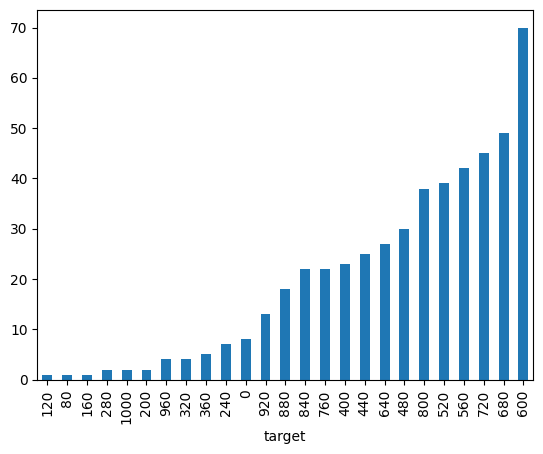

In [229]:
df_dataset.target.value_counts().sort_values().plot(kind="bar")

In [230]:
import numpy as np

count_values = df_dataset.target.value_counts()
low_counts =  count_values >= 6

filtered_df = df_dataset[np.isin(df_dataset.score, count_values[low_counts].index)]
filtered_df

,text,target,C1,C2,C3,C4,C5,score,prompt
1816,O suicídio é o ato de acabar com a própria vid...,720,120,160,120,160,160,720,O suicídio pode ser causado por vários fatores...
446,"Anos após anos Ano após ano, uma vaga de empre...",480,80,120,120,80,80,480,O número de pessoas desempregadas no mundo dev...
331,"O aumento do aquecimento global provocou, no í...",560,80,120,120,120,120,560,As mudanças que afetam o clima de nosso planet...
4328,O feminicídio caracteriza-se por ser a última ...,720,120,160,160,160,120,720,Feminicídio é o assassinato de uma mulher pela...
699,O Ministério da Cultura não está nem um pouco ...,0,0,0,0,0,0,0,O patrimônio histórico e cultural brasileiro s...
...,...,...,...,...,...,...,...,...,...
1259,"A respeito do tema ""Manipulação do comportamen...",440,120,80,80,80,80,440,"Às segundas-feiras pela manhã, os usuários do ..."
733,Com uma educação de qualidade e disciplina exe...,440,80,120,80,80,80,440,Os colégios militares de vários Estados do Bra...
962,É de fundamental importância discutir a proble...,520,120,120,80,120,80,520,São chamados de analfabetos funcionais os indi...
3764,Pode ser afirmar que os impactos ambientais vm...,440,120,80,80,80,80,440,Segundo a resolução Conama Nº001 de janeiro de...


In [231]:
Y = filtered_df.loc[:, 'score'] / 1000

## Treinando o Modelo

### Extração de Características


Como abordado em diversos artigos, uma forma de realizar a classificação de redação é usando extração de características do texto.

In [232]:
import json

from aibox.nlp.factory import get_extractor

In [233]:
FEATURES_lIST = ['readabilityBR',
                  'regencyBR',
                  'syntacticComplexityBR',
                  'textualSimplicityBR']

TEXT_EXEMPLE = "O poeta modernista Oswald de Andrade relata, em \"Erro de Português\", que, sob um dia de chuva, o índio foi vestido pelo português - uma denúncia à aculturação sofrida pelos povos indígenas com a chegada dos europeus ao território brasileiro. Paralelamente, no Brasil atual, há a manutenção de práticas prejudiciais não só aos silvícolas, mas também aos demais povos e comunidades tradicionais, como os pescadores. Com efeito, atuam como desafios para a valorização desses grupos a educação deficiente acerca do tema e a ausência do desenvolvimento sustentável."

In [234]:
# === Obtendo um único extrator ===
readability_extractor = get_extractor(FEATURES_lIST)
extraction = readability_extractor.extract(TEXT_EXEMPLE)
features_dict = extraction.as_dict()
print( json.dumps(features_dict, indent=2, ensure_ascii=False))


{
  "adapted_dalechall": 5.09875968992248,
  "adverbs_before_main_verb_ratio": 0.16666666666666666,
  "brunet_indice": 9.066469756208491,
  "clauses_per_sentence": 2.0,
  "coord_conj_ratio": 1.0,
  "coordinate_conjunctions_per_clauses": 0.5,
  "dialog_pron_ratio": 0,
  "easy_conj_ratio": 0.12790697674418605,
  "flesch_indice": 30.863914728682204,
  "gunning_fox_indice": 11.606201550387597,
  "hard_conj_ratio": 0.023255813953488372,
  "honore_statistics": 1373.4939003829327,
  "infinite_subordinate_clauses": 0.3333333333333333,
  "long_sentence_ratio": 1.0,
  "medium_long_sentence_ratio": 0.0,
  "medium_short_sentence_ratio": 0.0,
  "nominal_regency_score": 1.0,
  "passive_ratio": 0.3333333333333333,
  "readibility_indice": 18.04158914728682,
  "sentences_with_1_clauses": 2,
  "sentences_with_2_clauses": 0,
  "sentences_with_3_clauses": 0,
  "sentences_with_4_clauses": 1,
  "sentences_with_5_clauses": 0,
  "sentences_with_6_clauses": 0,
  "sentences_with_7_clauses": 0,
  "short_sentence

In [235]:
import numpy as np
extraction = [features.as_numpy().tolist()
                        for features in map(readability_extractor.extract, filtered_df["text"])]

X = np.array(extraction)


X[:5]

array([[ 5.40147257e+00,  8.09523821e-01,  1.18470688e+01,
         2.09999990e+00,  4.81481493e-01,  6.19047642e-01,
         0.00000000e+00,  2.40687683e-01,  4.80900116e+01,
         1.40723209e+01,  8.59598815e-03,  9.27383362e+02,
         5.33333361e-01,  8.99999976e-01,  0.00000000e+00,
         0.00000000e+00,  8.57142866e-01,  1.42857149e-01,
         1.82474213e+01,  4.00000000e+00,  2.00000000e+00,
         3.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000001e-01,
         0.00000000e+00,  1.24997878e+00,  5.18518507e-01,
         5.73517380e+01,  1.00000000e+00,  4.00000000e+00],
       [ 5.40633583e+00,  5.00000000e-01,  1.08387089e+01,
         2.66666675e+00,  3.15789461e-01,  3.75000000e-01,
         0.00000000e+00,  2.76190490e-01,  3.48442841e+01,
         1.41428576e+01,  1.90476198e-02,  7.77943481e+02,
         3.18181813e-01,  8.33333313e-01,  0.00000000e+00,
         0.00000000e+00,  6.66666687e-01,  1.87500000e-

## Normalizando os dados

In [246]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

Y_transformed = filtered_df.target.to_numpy()

X_transformed.shape, Y.shape

((478, 33), (478,))

### Dividindo o Conjunto de Dados Train and Test






In [237]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# Separando os dados em treinamento(75%) e teste(25%)
sm = SMOTE(random_state=42, k_neighbors=2)
X_res, y_res = sm.fit_resample(X_transformed, Y_transformed) # Usando oversampling de classes minoritárias
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size = 0.25)

### Treinando com Modelos


Podemos treinar com o modelo caixa branca, neste caso, árvore de decisão. Objetivo é garantir a existência de um modelo baseline.
Além disso, completamos nossa análise com os modelos que são caixa preta e que precisão de uma análise de explicabilidade.

In [248]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, SVR

svc_clf = SVC(kernel="linear", C=0.025).fit(X_train, Y_train)
rf_clf = RandomForestClassifier(max_depth=12, random_state=0).fit(X_train, Y_train)
gb_clf = GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, max_depth=12, random_state=0).fit(X_train, Y_train)


In [249]:
clf_list = [svc_clf,rf_clf,gb_clf ]

In [260]:
from collections import defaultdict
from sklearn import metrics
import pandas as pd

def compute_metrics(models_list, x_test, y_test, metric_dict = {
        "cohen_kappa_score": {"weights":"quadratic"}
    }):
    report = defaultdict(list)
    metric_names = list(metric_dict.keys())
    for clf in models_list:
        y_hat = clf.predict(x_test)
        for metric in metric_names:
            score = getattr(metrics, metric)(y_hat, y_test, ** metric_dict[metric])
            report[clf.__class__.__name__].append(score)

    return pd.DataFrame.from_dict(report, orient='index', columns=metric_names)

### Analise dos Resultados

Por meio dos resultados podemos ver que os modelos tem resultados comparativos ruins entre si.

In [262]:

result = compute_metrics(clf_list, X_test, Y_test)
result


,cohen_kappa_score
SVC,0.710227
RandomForestClassifier,0.916256
GradientBoostingClassifier,0.826745
KNeighborsClassifier,0.764849


## Explicabilidade

### Global Surrogates

Global Surrogates é uma forma de explicabilidade que usa um modelo caixa branca, explicável para entender as saídas de um modelo caixa preta (não explicável).
É uma tentativa de obter uma explicação geral sobre o resultado final do modelo ao invés de explicar apenas uma saída.

No nosso caso, iremos utilizar o modelo Decision tree, caixa branca, para tentar explicar as saídas do modelo caixa preta.

In [252]:
from sklearn.tree import DecisionTreeRegressor

Y_hat = clf.predict(X_test)
dt_clf = DecisionTreeRegressor(max_depth=16).fit(X_test, Y_hat)

In [253]:
Y_hat_dt = dt_clf.predict(X_test)
print("Global Sogarrote accuracy: ", metrics.cohen_kappa_score(Y_hat, Y_hat_dt ))

Global Sogarrote accuracy:  1.0


### Permutation Feature Importance




In [254]:
from sklearn.inspection import permutation_importance
import pandas as pd

def calculate_pfi(model, x_test, y_test, feature_names):

    r = permutation_importance(model, x_test, y_test,
                            n_repeats=30,
                            random_state=0)

    features_df = []
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:

            print(f"{feature_names[i]:<8} "
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")
            features_df.append({
                "feature_names": feature_names[i],
                "mean": r.importances_mean[i],
                "std": r.importances_std[i]
            })

    return pd.DataFrame(features_df).set_index("feature_names")

Calculando Feature importance for model:  SVC
brunet_indice 0.043 +/- 0.010
words_before_main_verb 0.032 +/- 0.010
sentences_with_4_clauses 0.029 +/- 0.011
sentences_with_6_clauses 0.027 +/- 0.009
hard_conj_ratio 0.027 +/- 0.010
honore_statistics 0.027 +/- 0.009
sentences_with_3_clauses 0.026 +/- 0.010
sentences_with_1_clauses 0.025 +/- 0.008
medium_short_sentence_ratio 0.020 +/- 0.007
medium_long_sentence_ratio 0.019 +/- 0.008
adverbs_before_main_verb_ratio 0.018 +/- 0.008
gunning_fox_indice 0.018 +/- 0.007
adapted_dalechall 0.017 +/- 0.007
verb_regency_score 0.015 +/- 0.006
                                    mean       std
feature_names                                     
brunet_indice                   0.042976  0.010330
words_before_main_verb          0.031548  0.009631
sentences_with_4_clauses        0.029286  0.010848
sentences_with_6_clauses        0.027381  0.008956
hard_conj_ratio                 0.027143  0.010127
honore_statistics               0.027143  0.009476
sentences

KeyError: "None of ['feature_names'] are in the columns"

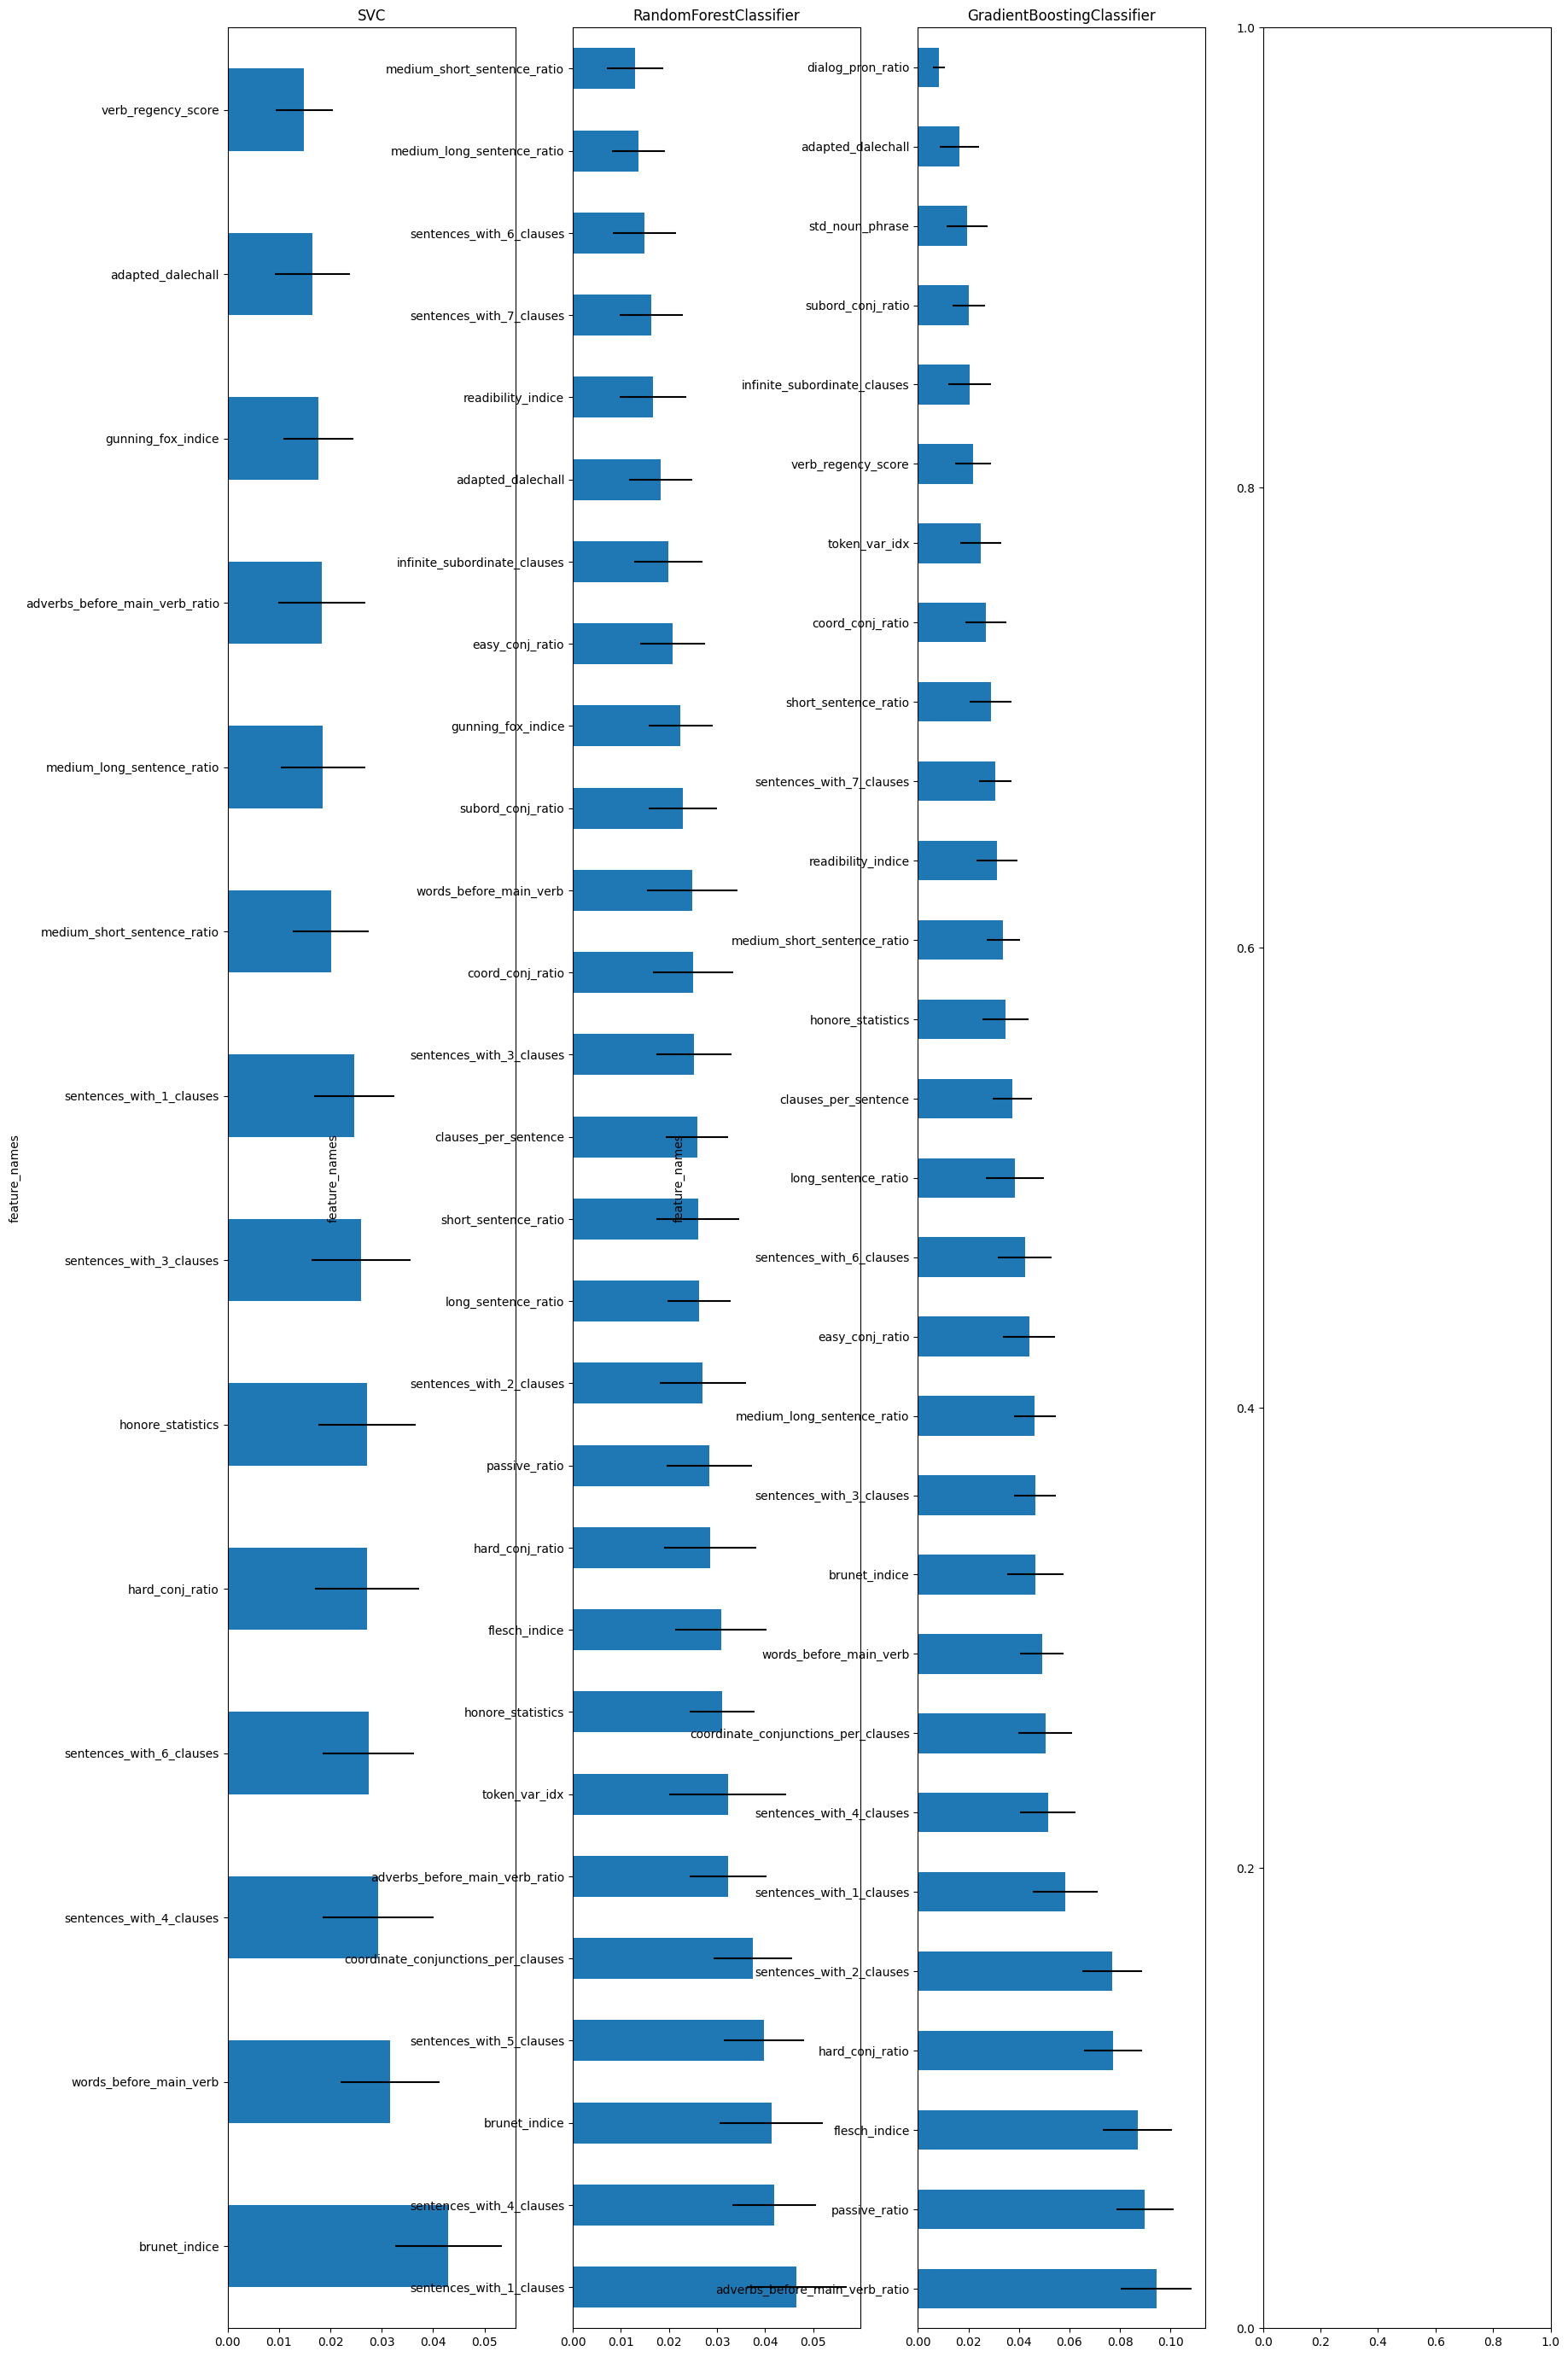

In [256]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, len(clf_list), figsize=(20,35))
feature_names = list(features_dict.keys())
for i, ml_class in enumerate(clf_list):

    ml_name = ml_class.__class__.__name__
    print("Calculando Feature importance for model: ", ml_name)
    df = calculate_pfi(ml_class, X_test, Y_test, feature_names)
    print(df)
    df.plot(kind = "barh", y = "mean", legend = False,
            title = ml_name, xerr = "std", ax=axes[i] if len(clf_list) > 1 else axes)
    print()
    print("-"*10)

### LIME

In [199]:
import lime
from lime import lime_text
import lime.lime_tabular as lime_tb

feature_names = np.array(list(features_dict.keys()))
class_names = set(Y_test)
explainer = lime_tb.LimeTabularExplainer(X_train, feature_names =     
                                 feature_names,  class_names=class_names, 
                                 mode = 'classification')

In [200]:
idx = 60
exp = explainer.explain_instance(X_test[idx], rf_clf.predict_proba, num_features=len(FEATURES_lIST))
print('Document id: %d' % idx)
print('Probability =', rf_clf.predict_proba([X_test[idx]])[0,1])
print('True class: %s' % Y_test[idx])
exp.as_list()


Document id: 60
Probability = 0.022467343976777937
True class: 360


[('flesch_indice > 0.65', 0.027596698588326928),
 ('sentences_with_2_clauses <= -0.75', 0.025334718669555237),
 ('honore_statistics > 0.43', -0.013945927445520312),
 ('-0.61 < words_before_main_verb <= -0.17', -0.011238662064172148)]

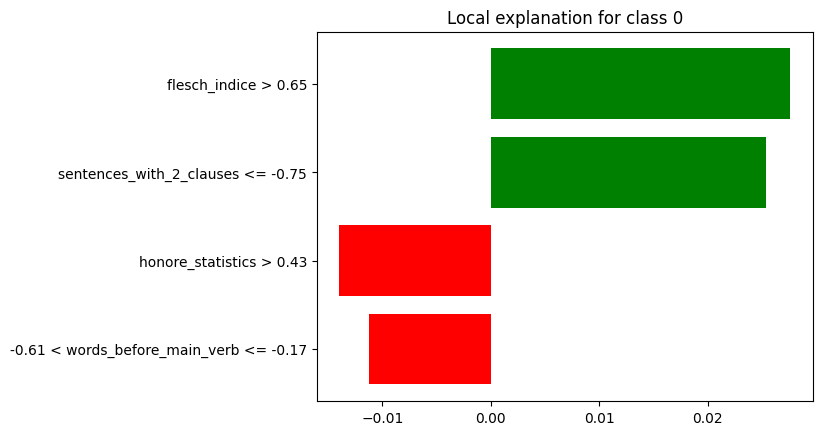

In [201]:
%matplotlib inline
fig = exp.as_pyplot_figure()

In [203]:
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# Create the explainer
explainer = shap.TreeExplainer(rf_clf)

shap_values = explainer.shap_values(X_test)

Variable Importance Plot - Global Interpretation


<Figure size 640x480 with 0 Axes>

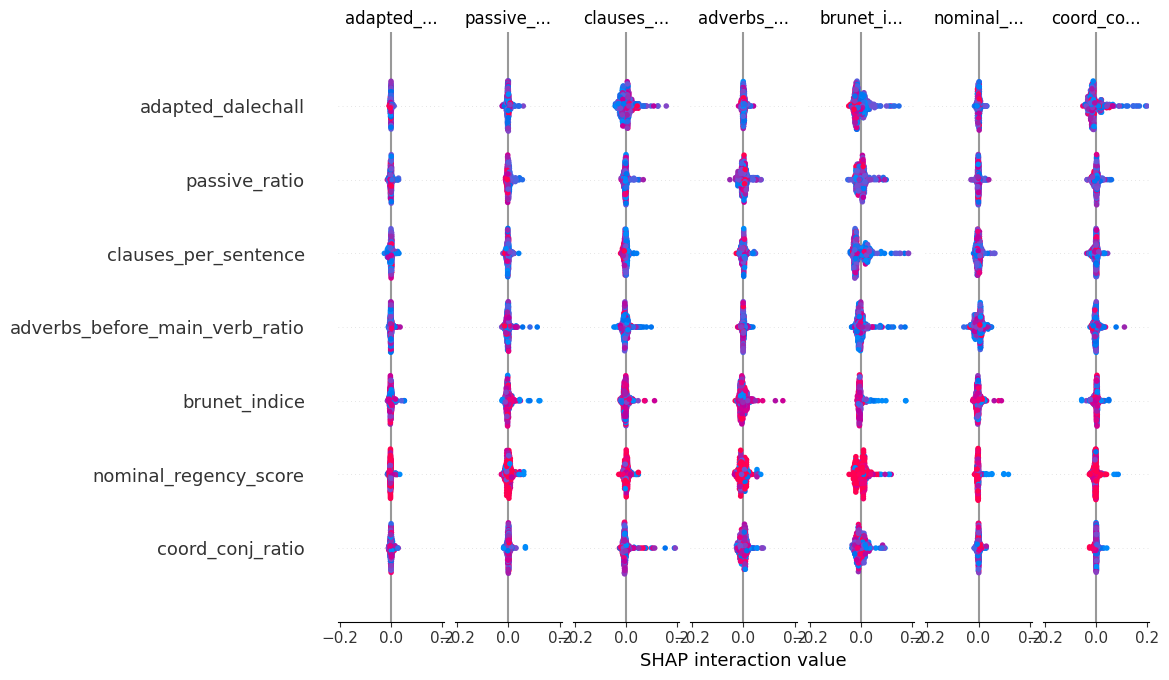

In [204]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test, class_names= class_names, feature_names = feature_names, plot_type="bar")

In [210]:
shap_values.shape, X_test.shape

((315, 33, 18), (315, 33))

In [213]:
explainer.expected_value.shape

(18,)

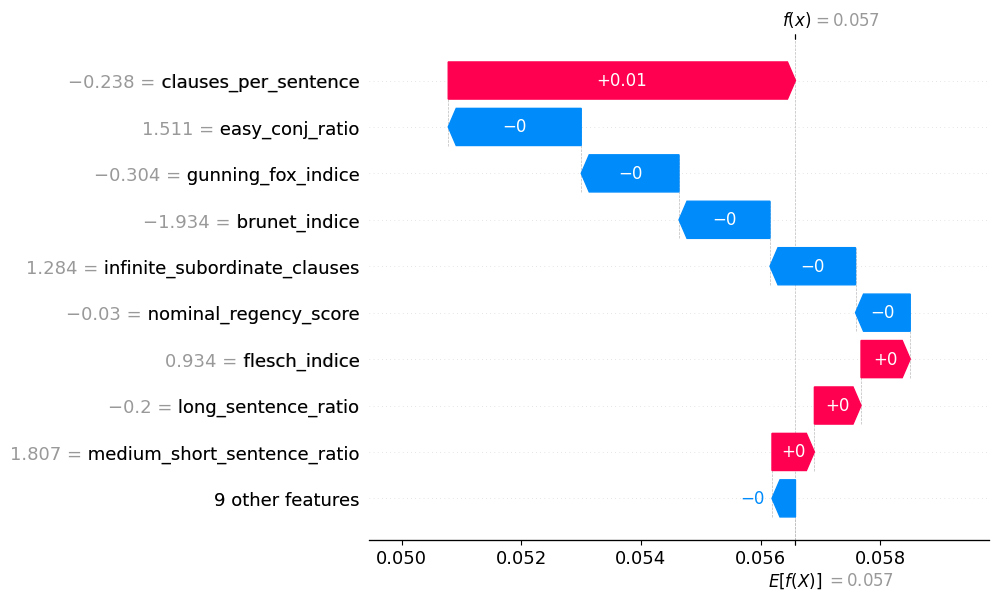

In [215]:

shap.waterfall_plot(shap.Explanation(values=shap_values[idx][0], 
                                              base_values=explainer.expected_value[0], data=X_test[idx],  
                                         feature_names=feature_names))